<a href="https://colab.research.google.com/github/leanring-machine/yt-classifier/blob/main/notebooks/svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Preprocess

In [1]:
from google.colab import drive
import os
import zipfile

drive_content = '/content/drive/MyDrive/yt-classifier/'
data_path = './thumbnail'

In [2]:
drive.mount('/content/drive')

local_zip = '/content/drive/MyDrive/yt-classifier/thumbnail.zip'

zip_ref = zipfile.ZipFile(drive_content + 'thumbnail.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

Mounted at /content/drive


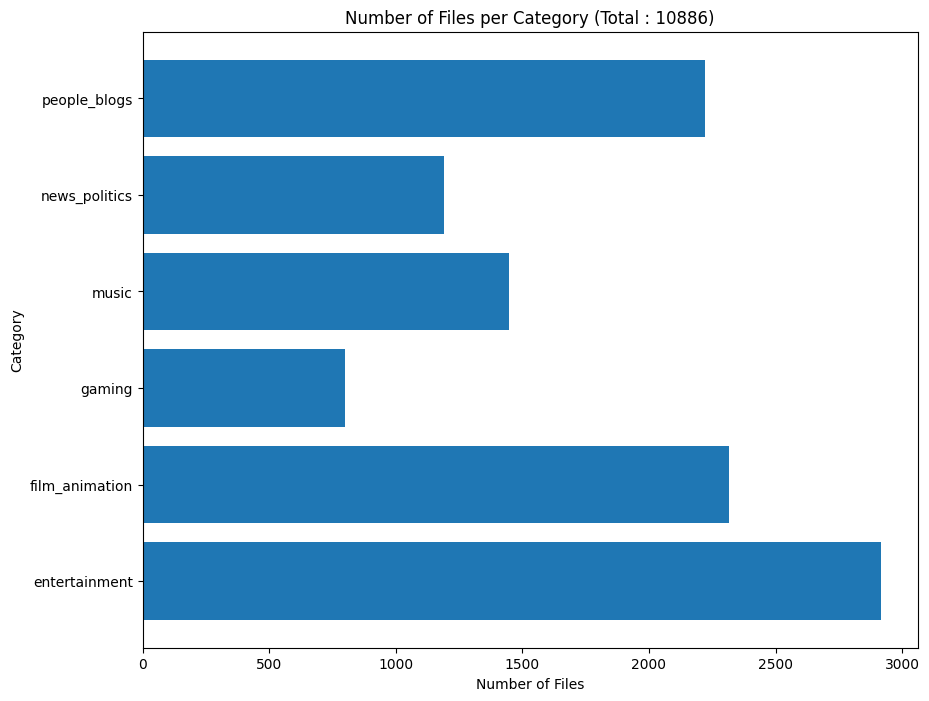

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

category_df = pd.read_csv(drive_content + 'video_category.csv')
category_info = category_df.set_index('id')['name'].to_dict()

selected_category = [
    'entertainment', 'film_animation', 'gaming',
    'music', 'news_politics', 'people_blogs'
]
category_counts = {}
vsum = 0
for c_value in selected_category:
  dir = os.path.join(data_path, c_value)
  category_counts[c_value] = len(os.listdir(dir))
  vsum += category_counts[c_value]

plt.figure(figsize=(10, 8))
plt.barh(list(category_counts.keys()), list(category_counts.values()))
plt.xlabel('Number of Files')
plt.ylabel('Category')
plt.title(f'Number of Files per Category (Total : {vsum})')
plt.show()

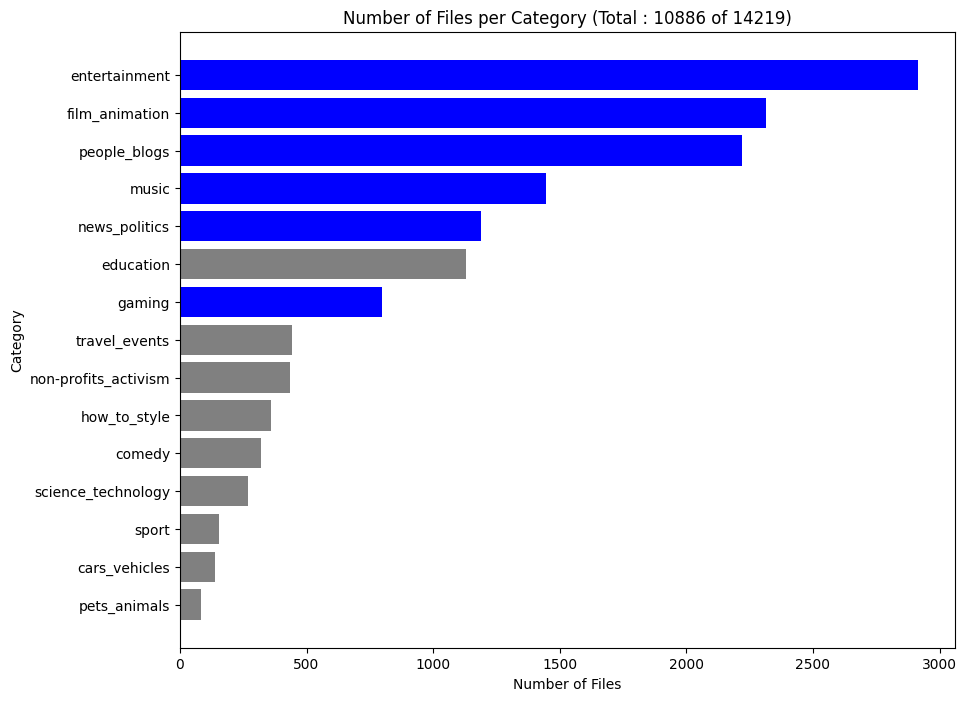

In [15]:
tsum = 0
data = []

for c_value in category_info.values():
  dir = os.path.join(data_path, c_value)
  data.append([len(os.listdir(dir)), c_value])
  tsum += data[-1][0]
data.sort()

plt.figure(figsize=(10, 8))
plt.barh(
    [d[1] for d in data],
    [d[0] for d in data],
    color=(['grey'] * 8 + ['blue', 'grey'] + ['blue'] * 5)
)
plt.xlabel('Number of Files')
plt.ylabel('Category')
plt.title(f'Number of Files per Category (Total : {vsum} of {tsum})')
plt.show()

## 1. SVM

In [16]:
from skimage.transform import resize
from skimage.io import imread
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import numpy as np

flat_data_arr=[] #input array
target_arr=[] #output array

category_value_key = {val:key for key,val in category_info.items()}

#path which contains all the categories of images
for c in selected_category:
    print(f'loading... category : {c}')
    path = os.path.join(data_path, c)
    for img in os.listdir(path):
        img_array=imread(os.path.join(path,img))
        img_resized=resize(img_array,(150, 150, 3))
        flat_data_arr.append(img_resized.flatten())
        target_arr.append(category_value_key[c])
    print(f'loaded category:{c} successfully')
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)

loading... category : entertainment
loaded category:entertainment successfully
loading... category : film_animation
loaded category:film_animation successfully
loading... category : gaming
loaded category:gaming successfully
loading... category : music
loaded category:music successfully
loading... category : news_politics
loaded category:news_politics successfully
loading... category : people_blogs
loaded category:people_blogs successfully


In [17]:
#dataframe
df=pd.DataFrame(flat_data) 
df['Target']=target
df.shape

(10886, 67501)

In [18]:
#input data 
x=df.iloc[:,:-1] 
#output data
y=df.iloc[:,-1]

In [19]:
del flat_data_arr
del target_arr

In [20]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.30,
                                               random_state=42,
                                               stratify=y)

In [21]:
# Creating a support vector classifier
svc=svm.SVC(probability=True, kernel='linear',gamma='auto', verbose=10)

# Creating a model using GridSearchCV with the parameters grid
# model=GridSearchCV(svc,param_grid, verbose=10)


In [22]:
from sklearn.ensemble import BaggingClassifier

# Bagging 분류기 생성
bag_clf = BaggingClassifier(
    svc,
    n_estimators=5,  # 4개의 SVC 분류기를 학습
    max_samples=0.5,  # 각 분류기는 훈련 세트의 50%를 사용
    bootstrap=True,   # 복원 추출을 사용
    n_jobs=-1,        # 가능한 모든 CPU 코어를 사용하여 병렬 학습
    random_state=42, verbose=10)

In [23]:
# Training the model using the training data
history = bag_clf.fit(x_train,y_train)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 58.3min remaining: 87.4min
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed: 58.3min remaining: 38.9min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 59.1min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 59.1min finished


In [24]:
# Testing the model using the testing data
y_pred = bag_clf.predict(x_test)

# Calculating the accuracy of the model
accuracy = accuracy_score(y_pred, y_test)

# Print the accuracy of the model
print(f"The model is {accuracy*100}% accurate")


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  7.6min remaining: 11.3min
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:  7.6min remaining:  5.1min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  7.8min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  7.8min finished


The model is 40.048989589712185% accurate


In [25]:
import joblib

#bag_clf.save('/content/drive/svm.keras')

joblib.dump(bag_clf, '/content/drive/MyDrive/yt-classifier/svm_bagging_5.pkl')
joblib.dump(history, '/content/drive/MyDrive/yt-classifier/svm_bagging_5_history.pkl')

['/content/drive/MyDrive/yt-classifier/svm_bagging_5_history.pkl']

TypeError: ignored

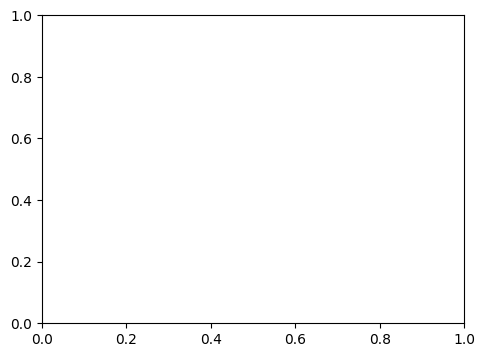

In [27]:
import matplotlib.pyplot as plt

# 학습 과정 시각화
def plot_training_history(history):
    # 정확도 그래프
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)    
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # 손실 함수 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# 학습 과정 시각화
plot_training_history(history)